<a href="https://colab.research.google.com/github/Sekuloska/diabetes-nutrition-analysis/blob/master/DiabetesRiskML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from functools import reduce

The model uses a Random Forest with Leave-One-Out cross-validation to predict diabetes prevalence based on nutritional and health indicators.

We have collected multiple datasets from different sources. First, we need to merge them all and create a pivot table to combine all indicators along with the target column into a single final dataset.

This dataset contains the target variable: the number of people with diabetes (in thousands), which serves as the outcome for our predictive modeling.


In [ ]:

df_pw = pd.read_csv(
    '/content/drive/MyDrive/targte_indikator.csv',
    skiprows=2,
    names=['Country', 'People with diabetes, in 1,000s'],
    usecols=[0, 1]
)

df_pw = df_pw[df_pw['Country'].notna() & (df_pw['Country'] != '')]

df_pw['People with diabetes, in 1,000s'] = pd.to_numeric(
    df_pw['People with diabetes, in 1,000s'],
    errors='coerce'
)

df_pw = df_pw.set_index('Country')

In [ ]:
df_pw

,"People with diabetes, in 1,000s"
Country,
Africa,14700.0
Europe,52770.8
Middle East and North Africa,32600.0
North America and Caribbean,37700.0
South and Central America,25121.5
...,...
Viet Nam,1702.7
Western Sahara,NaN
Yemen,727.1


The first dataset contains diabetes prevalence, total population, overweight prevalence among adults, and per capita alcohol consumption estimates.

In [ ]:
df_world = pd.read_csv('/content/drive/MyDrive/world bank 2.csv')

df_world_pivot = df_world.pivot_table(
    index='Country Name',
    columns='Series Name',
    values='2016 [YR2016]',
    aggfunc='first'
)

df_world_pivot.index.name = 'Country'

In [ ]:
df_world_pivot

Series Name,Diabetes prevalence (% of population ages 20 to 79),"Population, total",Prevalence of overweight (% of adults),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)"
Country,,,,
Afghanistan,..,34700612,38.89,0.013
Africa Eastern and Southern,..,623369401,25.2507944788883,4.65724427549811
Africa Western and Central,..,429454743,29.0666245823661,4.35854042948613
Albania,..,2876101,59.7,5.13
Algeria,..,40850721,53.46,0.6
...,...,...,...,...
West Bank and Gaza,..,4367088,68.34,..
World,..,7528523333.5,38.9,5.79476782889547
"Yemen, Rep.",..,32109010,33.15,0.031


The second dataset includes average dietary energy and nutrient supply metrics over three years, along with obesity prevalence, food supply variability, and anemia rates among women of reproductive age.

In [ ]:
df_hrana = pd.read_csv('/content/drive/MyDrive/diabetes hrana.csv')

df_hrana_pivot = df_hrana.pivot(
    index='Area',
    columns='Item',
    values='Value'
)
df_hrana_pivot.columns = df_hrana_pivot.columns.astype(str)

In [ ]:
df_hrana_pivot

Item,Average dietary energy supply adequacy (percent) (3-year average),Average fat supply (g/cap/day) (3-year average),Average protein supply (g/cap/day) (3-year average),Average supply of protein of animal origin (g/cap/day) (3-year average),Number of obese adults (18 years and older) (million),Per capita food supply variability (kcal/cap/day),Prevalence of anemia among women of reproductive age (15-49 years) (percent)
Area,,,,,,,
Afghanistan,105,37.2,64.2,12.3,1.3,62,37.1
Albania,132,106.2,111,58.3,0.4,64,21.3
Algeria,142,93.4,92.7,28.1,4.5,23,33.1
American Samoa,NaN,NaN,NaN,NaN,<0.1,NaN,NaN
Andorra,NaN,NaN,NaN,NaN,<0.1,NaN,10.5
...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),124,104.8,83.9,49.8,4.2,151,20.9
Viet Nam,120,53.5,83,32.3,0.5,25,17
Yemen,104,43.4,62.6,13.3,1.1,54,61.8


The third dataset includes key nutritional supply indicators such as carbohydrates, energy, fat, magnesium, protein, and several vitamins and minerals relevant to health analysis.

In [ ]:
df_makro = pd.read_csv('/content/drive/MyDrive/Makronutrienti.csv')

df_makro_pivot = df_makro.pivot_table(
    index='Area',
    columns='Indicator',
    values='Value',
    aggfunc='first'
)
df_makro_pivot.columns = df_makro_pivot.columns.astype(str)

In [ ]:
df_makro_pivot

Indicator,Carbohydrate (available) supply,Energy supply,Fat supply,Magnesium supply,Protein supply,Vitamin B12 supply,Vitamin B6 supply,Vitamin C supply,Zinc supply
Area,,,,,,,,,
Afghanistan,2.9,49.0,2.7,28.0,2.5,NaN,NaN,0.0,0.42
Albania,8.3,81.0,2.7,34.0,4.0,NaN,NaN,1.0,0.61
Algeria,9.2,89.0,2.6,35.0,5.3,NaN,NaN,1.0,0.77
Angola,9.0,92.0,3.0,41.0,5.5,NaN,NaN,0.0,0.74
Antigua and Barbuda,3.6,51.0,2.5,18.0,2.7,NaN,NaN,0.0,0.39
...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),6.8,55.0,1.0,24.0,3.4,NaN,NaN,0.0,0.49
Viet Nam,5.5,107.0,5.6,50.0,6.7,NaN,NaN,0.0,0.86
Yemen,6.4,62.0,1.8,28.0,3.7,NaN,NaN,1.0,0.57


The fourth dataset contains nutrition-related information, including various dietary indicators that are important for understanding their impact on health and diabetes.

In [ ]:
df_sug = pd.read_csv('/content/drive/MyDrive/hrana sekeri .csv')

df_sug_pivot = df_sug.pivot(
    index='Area',
    columns='Item',
    values='Value'
)
df_sug_pivot.columns = df_sug_pivot.columns.astype(str)


In [ ]:
df_sug_pivot

Item,Coconut Oil,"Fruits, other",Honey,Olive Oil,"Oranges, Mandarines",Palm Oil,Sugar (Raw Equivalent),"Sweeteners, Other","Vegetables, other"
Area,,,,,,,,,
Afghanistan,NaN,9.51,0.56,0.46,3.67,80.83,124.26,3.13,20.06
Albania,NaN,58.33,9.80,65.30,13.76,NaN,214.61,19.32,114.00
Algeria,1.06,36.57,1.42,42.23,24.43,8.96,272.75,7.37,81.86
Angola,0.00,12.88,8.08,3.60,0.13,155.96,105.64,11.23,18.40
Antigua and Barbuda,0.83,132.61,2.93,21.70,9.86,NaN,222.94,30.21,45.13
...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),4.62,31.84,0.17,5.61,16.18,62.62,393.45,5.31,28.96
Viet Nam,16.37,41.61,0.00,0.13,4.85,NaN,183.21,5.79,56.05
Yemen,1.18,21.83,0.83,1.74,4.90,149.82,255.69,13.86,9.22


Country names from multiple datasets were standardized in the code to ensure consistency before merging.

In [ ]:
print(sorted(df_pw.index.unique()))
print(sorted(df_world_pivot.index.unique()))
print(sorted(df_hrana_pivot.index.unique()))
print(sorted(df_makro_pivot.index.unique()))
print(sorted(df_sug_pivot.index.unique()))

['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', "Côte d'Ivoire", "Dem. People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Europe', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia',

In [ ]:
output_path = '/content/drive/MyDrive/country_lists1.txt'

with open(output_path, 'w', encoding='utf-8') as f:
    f.write("=== target dataset  countries ===\n")
    for c in sorted(df_pw.index.unique()):
        f.write(f"{c}\n")
    f.write("\n=== df_world_pivot countries ===\n")
    for c in sorted(df_world_pivot.index.unique()):
        f.write(f"{c}\n")
    f.write("\n=== df_hrana_pivot countries ===\n")
    for c in sorted(df_hrana_pivot.index.unique()):
        f.write(f"{c}\n")
    f.write("\n=== df_makro_pivot countries ===\n")
    for c in sorted(df_makro_pivot.index.unique()):
        f.write(f"{c}\n")
    f.write("\n=== df_sugar_pivot countries ===\n")
    for c in sorted(df_sug_pivot.index.unique()):
        f.write(f"{c}\n")


print(f"country_lists.txt е зачуван во {output_path}")


country_lists.txt е зачуван во /content/drive/MyDrive/country_lists1.txt


In [ ]:
all_countries = (
    set(df_pw.index)
    | set(df_world_pivot.index)
    | set(df_hrana_pivot.index)
    | set(df_makro_pivot.index)
    | set(df_sug_pivot.index)
)

presence = pd.DataFrame(index=sorted(all_countries))
presence['People with diabetes']    = presence.index.isin(df_pw.index)
presence['World Bank 2016']         = presence.index.isin(df_world_pivot.index)
presence['Diabetes hrana 2011']     = presence.index.isin(df_hrana_pivot.index)
presence['Makronutrienti 2011']     = presence.index.isin(df_makro_pivot.index)
presence['Hrana sekeri 2011']       = presence.index.isin(df_sug_pivot.index)

counts = presence.sum().rename('count')


In [ ]:
counts

,count
People with diabetes,223
World Bank 2016,266
Diabetes hrana 2011,204
Makronutrienti 2011,180
Hrana sekeri 2011,180


In [ ]:
common_all_five = presence[presence.sum(axis=1) == 5].index.tolist()
print("Држави што се појавуваат во сите пет датасети:", common_all_five)
len(common_all_five)

Држави што се појавуваат во сите пет датасети: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho',

152

After merging all datasets, we perform pivoting to organize the data with all indicators and the target variable in a unified format.

In [ ]:
dfs = [
    df_pw,
    df_world_pivot,
    df_hrana_pivot,
    df_makro_pivot,
    df_sug_pivot
]

merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        left_index=True, right_index=True,
        how='outer'
    ),
    dfs
)



In [ ]:
merged

,"People with diabetes, in 1,000s",Diabetes prevalence (% of population ages 20 to 79),"Population, total",Prevalence of overweight (% of adults),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Average dietary energy supply adequacy (percent) (3-year average),Average fat supply (g/cap/day) (3-year average),Average protein supply (g/cap/day) (3-year average),Average supply of protein of animal origin (g/cap/day) (3-year average),Number of obese adults (18 years and older) (million),...,Zinc supply,Coconut Oil,"Fruits, other",Honey,Olive Oil,"Oranges, Mandarines",Palm Oil,Sugar (Raw Equivalent),"Sweeteners, Other","Vegetables, other"
Afghanistan,818.3,..,34700612,38.89,0.013,105,37.2,64.2,12.3,1.3,...,0.42,NaN,9.51,0.56,0.46,3.67,80.83,124.26,3.13,20.06
Africa,14700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Eastern and Southern,NaN,..,623369401,25.2507944788883,4.65724427549811,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Western and Central,NaN,..,429454743,29.0666245823661,4.35854042948613,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,64.1,..,2876101,59.7,5.13,132,106.2,111,58.3,0.4,...,0.61,NaN,58.33,9.80,65.30,13.76,NaN,214.61,19.32,114.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
World,NaN,..,7528523333.5,38.9,5.79476782889547,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,727.1,NaN,NaN,NaN,NaN,104,43.4,62.6,13.3,1.1,...,0.57,1.18,21.83,0.83,1.74,4.90,149.82,255.69,13.86,9.22
"Yemen, Rep.",NaN,..,32109010,33.15,0.031,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zambia,243.8,..,16914423,24.88,3.75,92,48.5,49.7,13,0.4,...,1.27,0.33,9.24,0.21,0.21,0.66,54.07,98.81,4.24,17.46


Country names are manually standardized across datasets using a mapping dictionary to ensure consistency.

In [ ]:
name_corrections_manual = {
    'Bahamas, The':   'Bahamas',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Democratic Republic of the Congo': 'Congo',

    'Congo, Dem. Rep.':   'Congo',
    'Congo, Rep.': 'Congo',

    "Cote d'Ivoire":    "Côte d'Ivoire",
    "Dem. People's Republic of Korea":           'Republic of Korea',

    "Korea, Dem. People's Rep.": 'Republic of Korea',
    'Korea, Rep.': 'Republic of Korea',

    "Democratic People's Republic of Korea":         "Republic of Korea",

    "Dominican Republic":         "Dominica",

    "Egypt, Arab Rep.": "Eqypt",
    "Gambia, The":"Gambia",
    "Iran, Islamic Rep.":"Iran (Islamic Republic of)",
    "Kyrgyz Republic":"Kyrgyzstan",
    "Lao PDR":"Lao People's Democratic Republic",
    "Netherlands (Kingdom of the)":"Netherlands",
    "Moldova":"Republic of Moldova",
    "St. Kitts and Nevis":"Saint Kitts and Nevis",
    "St. Lucia":"Saint Lucia",
    "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
    "Slovak Republic":"Slovakia",
    "United Kingdom of Great Britain and Northern Ireland":"United Kingdom",
    "United Republic of Tanzania":"Tanzania",
    "United States":"United States of America",
    "Venezuela, RB":"Venezuela (Bolivarian Republic of)",
    "Yemen, Rep.":"Yemen",
    "Turkiye":              "Türkiye",

}


merged.index = merged.index.to_series().replace(name_corrections_manual).values

merged_clean = merged.groupby(merged.index).first()
merged_clean

merged_clean.to_csv('/content/drive/MyDrive/merged_standardized_countries2.csv', encoding='utf-8')

In [ ]:
merged_clean

,"People with diabetes, in 1,000s",Diabetes prevalence (% of population ages 20 to 79),"Population, total",Prevalence of overweight (% of adults),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Average dietary energy supply adequacy (percent) (3-year average),Average fat supply (g/cap/day) (3-year average),Average protein supply (g/cap/day) (3-year average),Average supply of protein of animal origin (g/cap/day) (3-year average),Number of obese adults (18 years and older) (million),...,Zinc supply,Coconut Oil,"Fruits, other",Honey,Olive Oil,"Oranges, Mandarines",Palm Oil,Sugar (Raw Equivalent),"Sweeteners, Other","Vegetables, other"
Afghanistan,818.3,..,34700612,38.89,0.013,105,37.2,64.2,12.3,1.3,...,0.42,NaN,9.51,0.56,0.46,3.67,80.83,124.26,3.13,20.06
Africa,14700.0,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Eastern and Southern,NaN,..,623369401,25.2507944788883,4.65724427549811,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Western and Central,NaN,..,429454743,29.0666245823661,4.35854042948613,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,64.1,..,2876101,59.7,5.13,132,106.2,111,58.3,0.4,...,0.61,NaN,58.33,9.80,65.30,13.76,NaN,214.61,19.32,114.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Western Sahara,NaN,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
World,NaN,..,7528523333.5,38.9,5.79476782889547,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,727.1,..,32109010,33.15,0.031,104,43.4,62.6,13.3,1.1,...,0.57,1.18,21.83,0.83,1.74,4.90,149.82,255.69,13.86,9.22
Zambia,243.8,..,16914423,24.88,3.75,92,48.5,49.7,13,0.4,...,1.27,0.33,9.24,0.21,0.21,0.66,54.07,98.81,4.24,17.46


In [ ]:

rows_to_keep = [
    "Afghanistan",
    "Albania",
    "Algeria",
    "Angola",
    "Antigua and Barbuda",
    "Argentina",
    "Armenia",
    "Australia",
    "Austria",
    "Azerbaijan",
    "Bahamas",
    "Bangladesh",
    "Barbados",
    "Belarus",
    "Belgium",
    "Belize",
    "Benin",
    "Bolivia",
    "Bosnia and Herzegovina",
    "Botswana",
    "Brazil",
    "Bulgaria",
    "Burkina Faso",
    "Burundi",
    "Cabo Verde",
    "Cambodia",
    "Cameroon",
    "Canada",
    "Central African Republic",
    "Chad",
    "Chile",
    "China",
    "China, Hong Kong SAR",
    "China, Macao SAR",
    "China, Taiwan Province of",
    "China, mainland",
    "Colombia",
    "Comoros",
    "Congo",
    "Costa Rica",
    "Croatia",
    "Cuba",
    "Cyprus",
    "Czechia",
    "Côte d'Ivoire",
    "Republic of Korea",
    "Denmark",
    "Djibouti",
    "Dominica",
    "Ecuador",
    "Egypt",
    "El Salvador",
    "Estonia",
    "Eswatini",
    "Ethiopia",
    "Fiji",
    "Finland",
    "France",
    "French Polynesia",
    "Gabon",
    "Gambia",
    "Georgia",
    "Germany",
    "Ghana",
    "Greece",
    "Grenada",
    "Guatemala",
    "Guinea",
    "Guinea-Bissau",
    "Guyana",
    "Haiti",
    "Honduras",
    "Hungary",
    "Iceland",
    "India",
    "Indonesia",
    "Iran (Islamic Republic of)",
    "Iraq",
    "Ireland",
    "Israel",
    "Italy",
    "Jamaica",
    "Japan",
    "Jordan",
    "Kazakhstan",
    "Kenya",
    "Kiribati",
    "Kuwait",
    "Kyrgyzstan",
    "Lao People's Democratic Republic",
    "Latvia",
    "Lebanon",
    "Lesotho",
    "Liberia",
    "Libya",
    "Lithuania",
    "Luxembourg",
    "Madagascar",
    "Malawi",
    "Malaysia",
    "Maldives",
    "Mali",
    "Malta",
    "Mauritania",
    "Mauritius",
    "Mexico",
    "Mongolia",
    "Montenegro",
    "Morocco",
    "Mozambique",
    "Myanmar",
    "Namibia",
    "Nepal",
    "Netherlands",
    "New Caledonia",
    "New Zealand",
    "Nicaragua",
    "Niger",
    "Nigeria",
    "North Macedonia",
    "Norway",
    "Oman",
    "Pakistan",
    "Panama",
    "Papua New Guinea",
    "Paraguay",
    "Peru",
    "Philippines",
    "Poland",
    "Portugal",
    "Republic of Korea",
    "Republic of Moldova",
    "Romania",
    "Russian Federation",
    "Rwanda",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Vincent and the Grenadines",
    "Samoa",
    "Sao Tome and Principe",
    "Saudi Arabia",
    "Senegal",
    "Serbia",
    "Seychelles",
    "Sierra Leone",
    "Slovakia",
    "Slovenia",
    "Solomon Islands",
    "Somalia",
    "South Africa",
    "Spain",
    "Sri Lanka",
    "Suriname",
    "Sweden",
    "Switzerland",
    "Syrian Arab Republic",
    "Tajikistan",
    "Thailand",
    "Timor-Leste",
    "Togo",
    "Trinidad and Tobago",
    "Tunisia",
    "Turkmenistan",
    "Türkiye",
    "Uganda",
    "Ukraine",
    "United Arab Emirates",
    "United Kingdom",
    "Tanzania",
    "United States of America",
    "Uruguay",
    "Uzbekistan",
    "Vanuatu",
    "Venezuela (Bolivarian Republic of)",
    "Viet Nam",
    "Yemen",
    "Zambia",
    "Zimbabwe"
]


finalDataset = merged_clean.loc[merged_clean.index.isin(rows_to_keep)]

print(f"Редови пред филтрирање: {merged_clean.shape[0]}")
print(f"Редови по филтрирање: {finalDataset.shape[0]}")
finalDataset.to_csv('/content/drive/MyDrive/final_dataset.csv', encoding='utf-8', index=True)


Редови пред филтрирање: 291
Редови по филтрирање: 177


In [ ]:
def replace_less_than(x):
    if isinstance(x, str) and x.startswith('<'):
        # извлекуаме бројот по '<' и го претвораме во float
        num = float(x[1:])
        return num / 2
    return x

finalDataset = finalDataset.applymap(replace_less_than)

for col in finalDataset.columns:
    finalDataset[col] = pd.to_numeric(finalDataset[col], errors='coerce')

for col in finalDataset.columns:
    median = finalDataset[col].median(skipna=True)
    finalDataset[col].fillna(median, inplace=True)

/tmp/ipython-input-46-452272874.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  finalDataset = finalDataset.applymap(replace_less_than)
/tmp/ipython-input-46-452272874.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  finalDataset[col].fillna(median, inplace=True)


In [ ]:
finalDataset.isnull().sum()
finalDataset.to_csv('/content/drive/MyDrive/dataset-diabetes.csv', index=True)

In [ ]:
finalDataset.drop(columns=["Diabetes prevalence (% of population ages 20 to 79)"], inplace=True)

Analysis of the correlation between all indicators and the target variable.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = finalDataset.corr()

target_col = 'People with diabetes, in 1,000s'
corr_with_target = corr_matrix[target_col].drop(target_col)

corr_with_target_sorted = corr_with_target.reindex(
    corr_with_target.abs().sort_values(ascending=False).index
)

print("Корелација на секој индикатор со таргетот (сортирано по апсолутна вредност):\n")
print(corr_with_target_sorted)

Корелација на секој индикатор со таргетот (сортирано по апсолутна вредност):

Population, total                                                                                       0.971439
Number of obese adults (18 years and older) (million)                                                   0.677511
Vegetables, other                                                                                       0.295344
Prevalence of overweight (% of adults)                                                                 -0.098650
Per capita food supply variability (kcal/cap/day)                                                      -0.087914
Energy supply                                                                                          -0.082753
Sugar (Raw Equivalent)                                                                                 -0.080327
Magnesium supply                                                                                       -0.078880
Fat supply        

In [ ]:
target = 'People with diabetes, in 1,000s'
corr_with_target = finalDataset.corr()[target].drop(target)

abs_corr = corr_with_target.abs().sort_values(ascending=False)
top_n = abs_corr.head(20).index.tolist()

print("Најсилно corr поврзаните индикатори со таргетот (до 20 колони):")
for col in top_n:
    print(f"{col}: {corr_with_target[col]:.2f}")

Најсилно corr поврзаните индикатори со таргетот (до 20 колони):
Population, total: 0.97
Number of obese adults (18 years and older) (million): 0.68
Vegetables, other: 0.30
Prevalence of overweight (% of adults): -0.10
Per capita food supply variability (kcal/cap/day): -0.09
Energy supply: -0.08
Sugar (Raw Equivalent): -0.08
Magnesium supply: -0.08
Fat supply: -0.08
Vitamin B6 supply: -0.08
Palm Oil: -0.07
Protein supply: -0.07
Zinc supply: -0.07
Average protein supply (g/cap/day) (3-year average): 0.06
Sweeteners, Other: 0.05
Carbohydrate (available) supply: -0.05
Average dietary energy supply adequacy (percent) (3-year average): 0.05
Vitamin B12 supply: -0.05
Coconut Oil: -0.05
Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age): 0.04


Trained a Random Forest Regressor with Leave-One-Out cross-validation using the top 20 indicators ranked by correlation with the target variable.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score



top20_features = [
    "Population, total",
    "Number of obese adults (18 years and older) (million)",
    "Vegetables, other",
    "Prevalence of overweight (% of adults)",
    "Per capita food supply variability (kcal/cap/day)",
    "Energy supply",
    "Sugar (Raw Equivalent)",
    "Magnesium supply",
    "Fat supply",
    "Vitamin B6 supply",
    "Palm Oil",
    "Protein supply",
    "Zinc supply",
    "Average protein supply (g/cap/day) (3-year average)",
    "Sweeteners, Other",
    "Carbohydrate (available) supply",
    "Average dietary energy supply adequacy (percent) (3-year average)",
    "Vitamin B12 supply",
    "Coconut Oil",
    "Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)"
]


target_col = 'People with diabetes, in 1,000s'
X = finalDataset[top20_features]
y_original = finalDataset[target_col]

y_log = np.log1p(y_original)

countries = finalDataset.index.to_numpy()

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

def run_rf_loocv_with_both_metrics(params, X_scaled, y_log, y_original, countries):
    loo = LeaveOneOut()
    y_true_log = []
    y_pred_log = []

    y_true_orig = []
    y_pred_orig = []

    results = []

    for train_idx, test_idx in loo.split(X_scaled):

        X_train = X_scaled.iloc[train_idx]
        X_test  = X_scaled.iloc[test_idx]
        y_train_log = y_log.iloc[train_idx]
        y_test_log  = y_log.iloc[test_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train_log)


        pred_log = model.predict(X_test)[0]


        y_true_log.append(y_test_log.values[0])
        y_pred_log.append(pred_log)


        idx = test_idx[0]
        actual_orig = y_original.iloc[idx]
        pred_orig = np.expm1(pred_log)

        y_true_orig.append(actual_orig)
        y_pred_orig.append(pred_orig)


        results.append({
            "Country": countries[idx],
            "Actual": actual_orig,
            "Predicted": pred_orig,
            "Error": abs(actual_orig - pred_orig)
        })


    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    r2_log   = r2_score(y_true_log, y_pred_log)


    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    r2_orig   = r2_score(y_true_orig, y_pred_orig)


    results_df = pd.DataFrame(results)


    print(f"\nRMSE (log-target)      = {rmse_log:.4f}")
    print(f"R²   (log-target)      = {r2_log:.4f}")
    print(f"RMSE (original)        = {rmse_orig:.4f}")
    print(f"R²   (original target) = {r2_orig:.4f}\n")


    pd.set_option('display.float_format', '{:,.2f}'.format)

    print("Првите 50 држави (оригинал):")
    print(results_df[['Country', 'Actual', 'Predicted']].head(50))

    print("\nПоследните 50 држави (оригинал):")
    print(results_df[['Country', 'Actual', 'Predicted']].tail(50))

    print("\nТоп 10 држави со најголема апсолутна грешка:")
    top_10_errors = results_df.nlargest(10, 'Error')[['Country', 'Actual', 'Predicted', 'Error']]
    print(top_10_errors)

    return results_df, rmse_log, r2_log, rmse_orig, r2_orig


rf_params = {
    'n_estimators':      300,
    'max_depth':         4,
    'min_samples_split': 2,
    'min_samples_leaf':  3,
    'random_state':      42
}

rf_results_df, rf_rmse_log, rf_r2_log, rf_rmse_orig, rf_r2_orig = run_rf_loocv_with_both_metrics(
    rf_params,
    X_scaled,
    y_log,
    y_original,
    countries
)


RMSE (log-target)      = 0.6335
R²   (log-target)      = 0.8930
RMSE (original)        = 6806.1027
R²   (original target) = 0.3535

Првите 50 држави (оригинал):
                      Country    Actual  Predicted
0                 Afghanistan    818.30     615.59
1                     Albania     64.10     153.89
2                     Algeria  1,435.10   1,799.49
3                      Angola    185.30     598.27
4         Antigua and Barbuda      7.30       5.72
5                   Argentina  1,531.80   2,111.44
6                     Armenia    191.70     125.00
7                   Australia  1,292.10   1,657.06
8                     Austria    571.00     325.77
9                  Azerbaijan    167.10     591.32
10                    Bahamas     28.80      17.80
11                 Bangladesh  8,405.60   1,743.15
12                   Barbados     29.10      15.13
13                    Belarus    676.60     586.79
14                    Belgium    514.90     527.80
15                    

Model trained with the top 10 indicators using Random Forest and Leave-One-Out cross-validation.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score


top10_features = [
    "Population, total",
    "Number of obese adults (18 years and older) (million)",
    "Vegetables, other",
    "Prevalence of overweight (% of adults)",
    "Per capita food supply variability (kcal/cap/day)",
    "Energy supply",
    "Sugar (Raw Equivalent)",
    "Fat supply",
    "Vitamin B6 supply"
]

target_col = 'People with diabetes, in 1,000s'


X = finalDataset[top10_features]
y_original = finalDataset[target_col]


y_log = np.log1p(y_original)

countries = finalDataset.index.to_numpy()


scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

def run_rf_loocv_with_both_metrics(params, X_scaled, y_log, y_original, countries):
    loo = LeaveOneOut()
    y_true_log = []
    y_pred_log = []

    y_true_orig = []
    y_pred_orig = []

    results = []

    for train_idx, test_idx in loo.split(X_scaled):

        X_train = X_scaled.iloc[train_idx]
        X_test  = X_scaled.iloc[test_idx]
        y_train_log = y_log.iloc[train_idx]
        y_test_log  = y_log.iloc[test_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train_log)

        pred_log = model.predict(X_test)[0]

        y_true_log.append(y_test_log.values[0])
        y_pred_log.append(pred_log)

        idx = test_idx[0]
        actual_orig = y_original.iloc[idx]
        pred_orig = np.expm1(pred_log)

        y_true_orig.append(actual_orig)
        y_pred_orig.append(pred_orig)

        results.append({
            "Country": countries[idx],
            "Actual": actual_orig,
            "Predicted": pred_orig,
            "Error": abs(actual_orig - pred_orig)
        })

    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    r2_log   = r2_score(y_true_log, y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    r2_orig   = r2_score(y_true_orig, y_pred_orig)

    results_df = pd.DataFrame(results)

    print(f"\nRMSE (log-target)      = {rmse_log:.4f}")
    print(f"R²   (log-target)      = {r2_log:.4f}")
    print(f"RMSE (original)        = {rmse_orig:.4f}")
    print(f"R²   (original target) = {r2_orig:.4f}\n")

    pd.set_option('display.float_format', '{:,.2f}'.format)

    print("Првите 50 држави (оригинал):")
    print(results_df[['Country', 'Actual', 'Predicted']].head(50))

    print("\nПоследните 50 држави (оригинал):")
    print(results_df[['Country', 'Actual', 'Predicted']].tail(50))

    print("\nТоп 10 држави со најголема апсолутна грешка:")
    top_10_errors = results_df.nlargest(10, 'Error')[['Country', 'Actual', 'Predicted', 'Error']]
    print(top_10_errors)

    return results_df, rmse_log, r2_log, rmse_orig, r2_orig


rf_params = {
    'n_estimators':      300,
    'max_depth':         4,
    'min_samples_split': 2,
    'min_samples_leaf':  3,
    'random_state':      42
}

rf_results_df, rf_rmse_log, rf_r2_log, rf_rmse_orig, rf_r2_orig = run_rf_loocv_with_both_metrics(
    rf_params,
    X_scaled,
    y_log,
    y_original,
    countries
)



RMSE (log-target)      = 0.6294
R²   (log-target)      = 0.8944
RMSE (original)        = 6733.2787
R²   (original target) = 0.3672

Првите 50 држави (оригинал):
                      Country    Actual  Predicted
0                 Afghanistan    818.30     619.20
1                     Albania     64.10     153.05
2                     Algeria  1,435.10   1,761.11
3                      Angola    185.30     647.37
4         Antigua and Barbuda      7.30       5.19
5                   Argentina  1,531.80   2,127.34
6                     Armenia    191.70     124.66
7                   Australia  1,292.10   1,658.29
8                     Austria    571.00     336.07
9                  Azerbaijan    167.10     549.21
10                    Bahamas     28.80      20.07
11                 Bangladesh  8,405.60   1,924.61
12                   Barbados     29.10      15.08
13                    Belarus    676.60     585.65
14                    Belgium    514.90     562.40
15                    

Final model using 10 selected indicators, outliers removed with Isolation Forest, and predictions printed for all countries.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score

X = finalDataset[top10_features]
y_original = finalDataset[target_col]
y_log = np.log1p(y_original)
countries = finalDataset.index.to_numpy()

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

iso = IsolationForest(contamination=0.05, random_state=42)
labels = iso.fit_predict(X_scaled)
mask = labels == 1

X_clean = X_scaled[mask]
y_log_clean = y_log[mask]
y_orig_clean = y_original[mask]
ct_clean = countries[mask]

print(f"Outliers removed: {len(X_scaled) - len(X_clean)} samples, remaining: {len(X_clean)}")

def run_rf_loocv_with_both_metrics(params, X_scaled, y_log, y_original, countries):
    loo = LeaveOneOut()
    y_true_log, y_pred_log = [], []
    y_true_orig, y_pred_orig = [], []
    results = []

    for train_idx, test_idx in loo.split(X_scaled):
        X_train = X_scaled.iloc[train_idx]
        X_test  = X_scaled.iloc[test_idx]
        y_train_log = y_log.iloc[train_idx]
        y_test_log  = y_log.iloc[test_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train_log)

        pred_log = model.predict(X_test)[0]
        idx      = test_idx[0]
        actual_o = y_original.iloc[idx]
        pred_o   = np.expm1(pred_log)

        y_true_log.append(y_test_log.values[0])
        y_pred_log.append(pred_log)
        y_true_orig.append(actual_o)
        y_pred_orig.append(pred_o)

        results.append({
            "Country":   countries[idx],
            "Actual":    actual_o,
            "Predicted": pred_o,
            "Error":     abs(actual_o - pred_o)
        })

    rmse_log  = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    r2_log    = r2_score(y_true_log, y_pred_log)
    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    r2_orig   = r2_score(y_true_orig, y_pred_orig)

    results_df = pd.DataFrame(results)

    pd.set_option('display.float_format', '{:,.2f}'.format)
    pd.set_option('display.max_rows', None)

    print(f"\nRMSE (log-target)      = {rmse_log:.4f}")
    print(f"R²   (log-target)      = {r2_log:.4f}")
    print(f"RMSE (original)        = {rmse_orig:.4f}")
    print(f"R²   (original target) = {r2_orig:.4f}\n")

    print("Сите држави со Actual и Predicted:")
    print(results_df[['Country', 'Actual', 'Predicted']])

    return results_df, rmse_log, r2_log, rmse_orig, r2_orig

rf_params = {
    'n_estimators':      300,
    'max_depth':         4,
    'min_samples_split': 2,
    'min_samples_leaf':  3,
    'random_state':      42
}

rf_results_df, rf_rmse_log, rf_r2_log, rf_rmse_orig, rf_r2_orig = run_rf_loocv_with_both_metrics(
    rf_params,
    X_clean,
    y_log_clean,
    y_orig_clean,
    ct_clean
)

Outliers removed: 9 samples, remaining: 168

RMSE (log-target)      = 0.6316
R²   (log-target)      = 0.8752
RMSE (original)        = 1206.6126
R²   (original target) = 0.6463

Сите држави со Actual и Predicted:
                                Country    Actual  Predicted
0                           Afghanistan    818.30     598.38
1                               Albania     64.10     150.53
2                               Algeria  1,435.10   1,616.18
3                                Angola    185.30     637.73
4                   Antigua and Barbuda      7.30       5.02
5                             Argentina  1,531.80   2,140.06
6                               Armenia    191.70     121.27
7                             Australia  1,292.10   1,421.50
8                               Austria    571.00     336.89
9                            Azerbaijan    167.10     490.65
10                              Bahamas     28.80      20.40
11                           Bangladesh  8,405.60   1,11

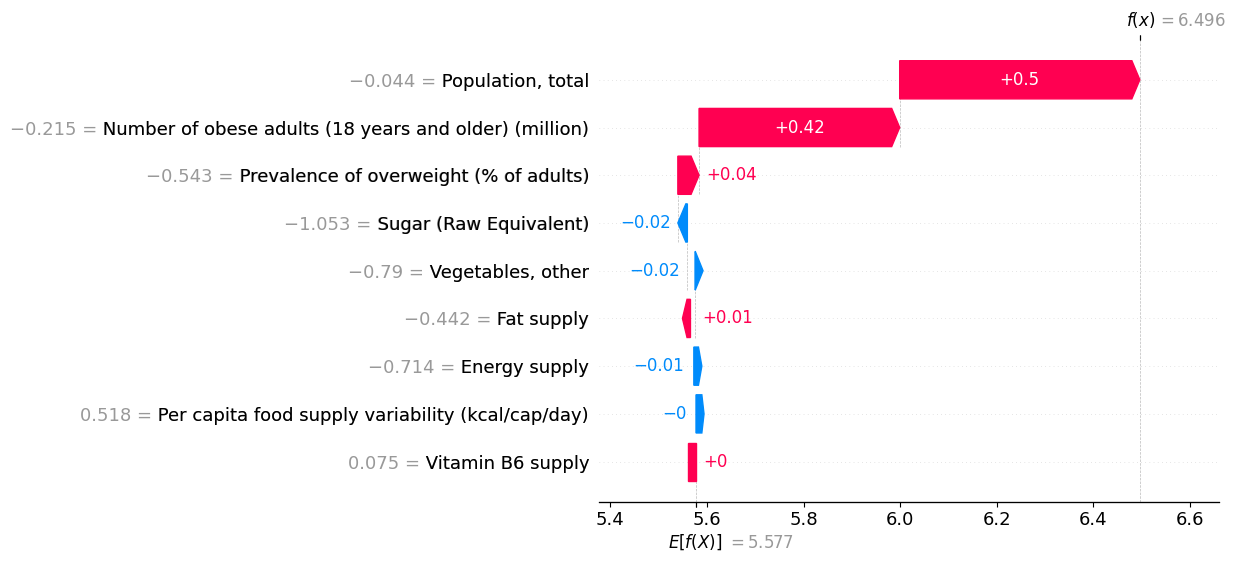

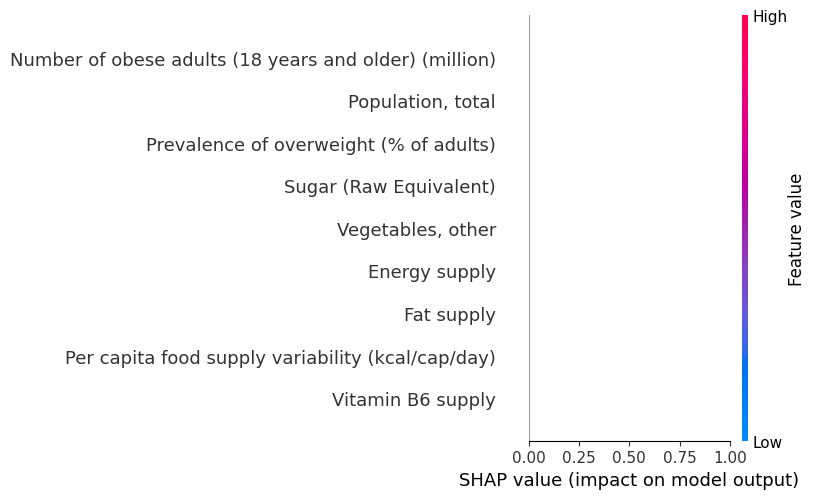

In [ ]:
import shap

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_clean, y_log_clean)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_clean)


sample_idx = 0
shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx],
                                      base_values=explainer.expected_value,
                                      data=X_clean.iloc[sample_idx],
                                      feature_names=X_clean.columns))


shap.summary_plot(shap_values, X_clean, plot_type="beeswarm")